In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Sebagai langkah pertama, kami akan mengimpor pustaka yang diperlukan dan akan mengonfigurasi nilai untuk berbagai parameter yang akan kami gunakan dalam kode. Pertama-tama mari kita mengimpor perpustakaan yang diperlukan:

In [2]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 64
EPOCHS = 200
LSTM_NODES =256
NUM_SENTENCES = 1000
MAX_SENTENCE_LENGTH = 200
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 300

#Dataset

Model terjemahan bahasa yang akan kami kembangkan dalam artikel ini akan menerjemahkan kalimat non-formal ke dalam kalimat formal dari bahasa Indonesia. 

Untuk mengembangkan model seperti itu, kita membutuhkan dataset yang berisi kalimat non-formal dan terjemahannya dalam kalimat formal. 


In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Dataset Kalimat').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

Dataset tersebut berada pada google sheet dengan nama file "Dataset Kalimat". Dengan menggunakan Dataframe dari Pandas, data tersebut dipisah menjadi 2 kolom dengan nama kolom "formal" dan "non-formal" 

In [0]:
# Convert to a DataFrame and render.
import pandas as pd
colsname=['formal','non-formal']
df = pd.DataFrame.from_records(rows,columns=colsname)

In [6]:
df = df[:3000]
df

,formal,non-formal
0,<unk>,<unk>
1,saat ini,sekarang
2,menjadi,jadi
3,akan,bakal
4,diberikan,kasih
...,...,...
2995,seperti pengemasan barang dan teknis pemasaran...,kayak pengemasan barang dan teknis pemasaran d...
2996,gerakan umkm go online diisi berbagai pelatihan,gerakan umkm go online diisi berbagai pelatihan
2997,kementerian komindo memfasilitasi umkm mengiku...,kementerian komindo memfasilitasi umkm ikuti p...
2998,namun masih terdapat sejumlah hal yang harus d...,namun tetep ada sejumlah hal yang mesti disele...


# Data Preprocessing

Model terjemahan mesin saraf sering didasarkan pada arsitektur seq2seq. Arsitektur seq2seq adalah arsitektur encoder-decoder yang terdiri dari dua jaringan LSTM: encoder LSTM dan decoder LSTM. Input ke encoder LSTM adalah kalimat dalam bahasa aslinya; input ke decoder LSTM adalah kalimat dalam bahasa yang diterjemahkan dengan token awal kalimat. Outputnya adalah kalimat target aktual dengan token akhir kalimat.

Dalam dataset kami, kami tidak perlu memproses input, namun, kami perlu membuat dua salinan dari kalimat yang diterjemahkan: satu dengan token awal kalimat dan yang lainnya dengan token akhir kalimat. Berikut ini skrip yang melakukan itu:

In [0]:
import re

In [0]:
def input_sen(w):
  w = w.lower()
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", w)
  w = w.rstrip().strip()

  return w

In [0]:
def output_sen(w):
  w = w.lower()
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", w)
  w = w.rstrip().strip()
  w = w + ' <end>'
  return w

In [0]:
def output_sen_in(w):
  w = w.lower()
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", w)
  w = w.rstrip().strip()
  w = '<sos> ' + w
  return w

In [0]:
input_sentences = []
for x in range(3000):
  input_sentences.append(input_sen(df['non-formal'][x]))

In [0]:
output_sentences = []
for x in range(3000):
  output_sentences.append(output_sen(df['formal'][x]))

In [0]:
output_sentences_inputs = []
for x in range(3000):
  output_sentences_inputs.append(output_sen_in(df['formal'][x]))

Pada skrip di atas kita membuat tiga daftar input_sentences [], output_sentences [], dan output_sentences_inputs []. 

Selanjutnya, dalam for loop tiap baris pada dataframe dibaca baris demi baris. 

input_sentences [] merupakan kalimat dari kolom non-formal dengan pengolahan kata.
output_sentences [] merupakan kalimat dari kolom formal dengan pengolahan kata ditambah token <end>.
output_sentences_inputs [] merupakan kalimat kolom formal dengan pengolahan kata ditambah token <sos>.

Token <end>, yang menandai akhir kalimat diawali dengan kalimat yang diterjemahkan, dan kalimat yang dihasilkan ditambahkan ke daftar output_sentences []. 
Demikian pula, token <sos>, yang merupakan singkatan dari "start of kalimat", digabungkan pada awal kalimat yang diterjemahkan dan hasilnya ditambahkan ke daftar output_sentences_inputs []. 

Simpul berakhir jika jumlah kalimat yang ditambahkan ke daftar lebih besar dari variabel NUM_SENTENCES.

Akhirnya jumlah sampel dalam tiga daftar ditampilkan dalam output:

In [14]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 3000
num samples output: 3000
num samples output input: 3000


print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

In [15]:
for i in range(200,250):
  print(input_sentences[i])
  print(output_sentences[i])
  print(output_sentences_inputs[i])
  print("-----------------------------------------")

kalo tawon ara punah , maka semua sistem pun akan jatoh , kata rosichon .
jika tawon ara punah , maka seluruh sistem pun akan jatuh , kata rosichon . <end>
<sos> jika tawon ara punah , maka seluruh sistem pun akan jatuh , kata rosichon .
-----------------------------------------
karena kita bergantung banget sama kekayaan keanekaragaman hayati .
karena kita sangat bergantung pada kekayaan keanekaragaman hayati . <end>
<sos> karena kita sangat bergantung pada kekayaan keanekaragaman hayati .
-----------------------------------------
kita harus bener bener kurangin dampak krisis
kita harus benar benar mengurangi dampak krisis <end>
<sos> kita harus benar benar mengurangi dampak krisis
-----------------------------------------
bmkg sebut pemicunya perubahan iklim .
bmkg sebut pemicunya perubahan iklim . <end>
<sos> bmkg sebut pemicunya perubahan iklim .
-----------------------------------------
curah ujan lebih deres
curah hujan lebih deras <end>
<sos> curah hujan lebih deras
------------

# Tokenization and Padding

Langkah selanjutnya adalah tokenizing kalimat asli dan terjemahan dan menerapkan padding pada kalimat yang lebih panjang atau lebih pendek dari panjang tertentu, yang dalam hal input akan menjadi panjang dari kalimat input terpanjang. Dan untuk output, ini akan menjadi panjang kalimat terpanjang dalam output.

Untuk tokenization, kelas Tokenizer dari pustaka keras.preprocessing.text dapat digunakan. Kelas tokenizer melakukan dua tugas:

     Ini membagi kalimat menjadi daftar kata yang sesuai
     Kemudian mengubah kata menjadi bilangan bulat

Ini sangat penting karena pembelajaran yang dalam dan algoritma pembelajaran mesin bekerja dengan angka. Skrip berikut digunakan untuk menandai token input kalimat:

In [16]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)
print(input_integer_seq[100])

Total unique words in the input: 5543
Length of longest sentence in input: 28
[3001, 6, 453, 8, 157, 1624]


In [17]:
print(input_sentences[100])
print(input_integer_seq[100])

hadiah itu dikasih buat para pemenang
[3001, 6, 453, 8, 157, 1624]


Selain tokenization dan konversi integer, atribut word_index dari kelas Tokenizer mengembalikan kamus kata-ke-indeks di mana kata-kata adalah kunci dan bilangan bulat yang sesuai adalah nilainya. Script di atas juga mencetak jumlah kata unik dalam kamus dan panjang kalimat terpanjang dalam input:

Demikian pula, kalimat-kalimat output juga dapat tokenized dengan cara yang sama seperti yang ditunjukkan di bawah ini:

In [18]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_integer_seq)
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
print('num_word_outputs:',num_words_output)
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

[[2905, 3], [36, 8, 3], [20, 3], [14, 3], [501, 3], [127, 3], [544, 3], [55, 3], [58, 3], [12, 3], [1612, 3], [656, 3], [120, 3], [819, 3], [373, 3], [42, 3], [24, 10, 13, 3], [1080, 3], [502, 3], [68, 3], [69, 3], [9, 3], [102, 3], [1081, 3], [173, 3], [1082, 3], [116, 3], [427, 24, 3], [1314, 3], [503, 3], [291, 3], [139, 3], [213, 3], [1613, 3], [927, 3], [1315, 3], [396, 3], [1614, 3], [128, 3], [723, 3], [1615, 3], [928, 3], [1316, 3], [374, 3], [230, 3], [66, 3], [2072, 3], [1083, 3], [929, 3], [930, 3], [58, 3], [1317, 3], [323, 1318, 3], [397, 3], [1084, 3], [1085, 3], [174, 3], [14, 3], [292, 3], [1616, 3], [197, 3], [545, 3], [820, 3], [595, 3], [324, 3], [2073, 3], [2906, 3], [1617, 3], [1319, 3], [286, 3], [1618, 3], [245, 3], [1619, 3], [821, 3], [596, 3], [198, 3], [190, 19, 2907, 3], [2908, 21, 504, 2909, 32, 3], [166, 2910, 2911, 3], [190, 19, 21, 1620, 3], [19, 21, 1086, 3], [1621, 2912, 822, 398, 3], [2913, 190, 20, 823, 2914, 3], [40, 21, 230, 1087, 50, 3], [40, 14, 

Dari perbandingan jumlah kata unik dalam input dan output, dapat disimpulkan bahwa kalimat bahasa Inggris biasanya lebih pendek dan mengandung lebih sedikit jumlah kata rata-rata, dibandingkan dengan kalimat bahasa Prancis yang diterjemahkan.

Selanjutnya, kita perlu mengisi input. Alasan di balik pengisian input dan output adalah bahwa kalimat teks dapat memiliki panjang yang berbeda-beda, namun LSTM (algoritma yang akan kita latih model kita) mengharapkan instance input dengan panjang yang sama. Karena itu, kita perlu mengubah kalimat kita menjadi vektor dengan panjang tetap. Salah satu cara untuk melakukan ini adalah melalui padding.

Dalam padding, panjang tertentu didefinisikan untuk kalimat. Dalam kasus kami, panjang kalimat terpanjang dalam input dan output akan digunakan untuk masing-masing kalimat input dan output. Kalimat terpanjang dalam input berisi 6 kata. Untuk kalimat yang mengandung kurang dari 6 kata, nol akan ditambahkan dalam indeks kosong. Script berikut berlaku padding ke kalimat input.

In [19]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[6]:", encoder_input_sequences[6])

encoder_input_sequences.shape: (3000, 28)
encoder_input_sequences[6]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 712]


Karena ada 1.100 kalimat dalam input dan setiap kalimat input panjang 25, bentuk input sekarang (1100, 25). Jika Anda melihat urutan bilangan bulat untuk kalimat pada indeks 6 dari kalimat input, Anda dapat melihat bahwa ada 8 nol, diikuti oleh nilai 1107,1109,5 dan seterusnya. Anda mungkin ingat bahwa kalimat asli pada indeks 6 kata pertama dan kedua "rino dan "menjelaskan". 
Tokenizer membagi kalimat menjadi beberapa kata, mengubahnya menjadi bilangan bulat, dan kemudian menerapkan pra-padding dengan menambahkan tiga nol pada awal urutan bilangan bulat yang sesuai untuk kalimat pada indeks 6 dari daftar input.

Untuk memverifikasi bahwa nilai integer untuk "rino" dan "menjelaskan" masing-masing adalah 1107 dan 1109, Anda bisa meneruskan kata-kata ke kamus word2index_inputs, seperti yang ditunjukkan di bawah ini:

In [20]:
print(word2idx_inputs["yang"])
print(word2idx_inputs["menjelaskan"])

1
1628


Save word2idx_inputs

In [0]:
# Save
np.save('word2idx_inputs.npy', word2idx_inputs) 

In [21]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[6]:", decoder_input_sequences[6])

decoder_input_sequences.shape: (3000, 35)
decoder_input_sequences[6]: [  4 544   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Kalimat pada 4 kata pertama di indeks 6 dari input dekoder adalah "<sos> rino menjelaskan, ... " 

Jika Anda mencetak bilangan bulat yang sesuai dari kamus word2idx_outputs, Anda akan melihat 4, 1126, 517, dan 1 dicetak pada konsol, seperti yang ditunjukkan di sini:

In [22]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["rino"])
print(word2idx_outputs["menjelaskan"])
print(word2idx_outputs[","])

4
2076
935
2


Save word2idx_outputs

In [0]:
# Save
np.save('word2idx_outputs.npy', word2idx_outputs)

Lebih lanjut penting untuk menyebutkan bahwa dalam kasus dekoder, post-padding diterapkan, yang berarti bahwa nol ditambahkan pada akhir kalimat. 

Di encoder, angka nol telah diisi di awal. Alasan di balik pendekatan ini adalah bahwa output encoder didasarkan pada kata-kata yang terjadi pada akhir kalimat, oleh karena itu kata-kata asli disimpan di akhir kalimat dan nol padded di awal. 

Di sisi lain, dalam kasus decoder, pemrosesan dimulai dari awal kalimat, dan oleh karena itu post padding dilakukan pada input dan output decoder.

# Word2Vec


Karena kita menggunakan model deep learning, dan model depp learning bekerja dengan angka, maka kita perlu mengubah kata-kata kita menjadi representasi vektor numerik yang sesuai. Tapi kami sudah mengubah kata-kata kami menjadi bilangan bulat. Jadi apa perbedaan antara representasi integer dan embedding kata?

Ada dua perbedaan utama antara representasi integer tunggal dan embedding kata. Dengan reprensentasi integer, sebuah kata diwakili hanya dengan integer tunggal. Dengan representasi vektor, sebuah kata diwakili oleh vektor 50, 100, 200, atau dimensi apa pun yang Anda suka. Karenanya, embeddings kata menangkap lebih banyak informasi tentang kata-kata. Kedua, representasi bilangan bulat tunggal tidak menangkap hubungan antara kata-kata yang berbeda. Sebaliknya, kata embeddings mempertahankan hubungan antara kata-kata. Anda dapat menggunakan embeddings kata kustom atau Anda dapat menggunakan embeddings kata pretrained.

pada penelitian ini, embedding dilakukan secara manual dari kalimat dalam dataset.  Dengan bantuan gensim.models, kita membangun word2vec secara mudah dan cepat.

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
#tokenize, dengan menghilangkan punctuation, dan mengubah digit menjadi #

from nltk import word_tokenize, sent_tokenize
import re
import string

puncts = string.punctuation
print(puncts)
    
sentences = []
for y in range(df.shape[0]):
    doc = sent_tokenize(df['formal'][y])
    sentence=[sent for sent in doc]
    for x in range(len(sentence)):
        words = [t for t in word_tokenize(sentence[x]) if t not in(puncts)]
        #words = [re.sub('\d','#',t) for t in word_tokenize(sentence[x]) if t not in(puncts)]
        sentences.append(words)
    doc = sent_tokenize(df['non-formal'][y])
    sentence=[sent for sent in doc]
    for x in range(len(sentence)):
        words = [t for t in word_tokenize(sentence[x]) if t not in(puncts)]
        #words = [re.sub('\d','#',t) for t in word_tokenize(sentence[x]) if t not in(puncts)]
        sentences.append(words)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [25]:
print(sentences)

[['unk'], ['unk'], ['saat', 'ini'], ['sekarang'], ['menjadi'], ['jadi'], ['akan'], ['bakal'], ['diberikan'], ['kasih'], ['dilakukan'], ['dilakuin'], ['dibutuhkan'], ['dibutuhin'], ['hanya'], ['cuma'], ['telah'], ['udah'], ['dengan'], ['sama'], ['ditunjukkan'], ['ditunjukkin'], ['berhenti'], ['berenti'], ['membuat'], ['bikin'], ['mengeluarkan'], ['ngeluarin'], ['seluruh'], ['semua'], ['sudah'], ['udah'], ['lebih', 'dari', 'itu'], ['apalagi'], ['mengumpulkan'], ['ngumpulin'], ['ditargetkan'], ['ditargetin'], ['hingga'], ['sampe'], ['jika'], ['kalau'], ['untuk'], ['buat'], ['memiliki'], ['punya'], ['mempertahankan'], ['pertahanin'], ['memberikan'], ['kasih'], ['menurunkan'], ['nurunin'], ['mengatakan'], ['bilang'], ['sedikit', 'lebih'], ['agak'], ['dipikirkan'], ['dipikirin'], ['menyerap'], ['nyerep'], ['mengembangkan'], ['ngembangin'], ['agar'], ['biar'], ['dibandingkan'], ['dibandingin'], ['diperbaiki'], ['dibetulin'], ['diarahkan'], ['diarahin'], ['disarankan'], ['disaranin'], ['menunj

In [0]:
from gensim.models import Word2Vec

model1 = Word2Vec(sentences, sg=1, size=EMBEDDING_SIZE, window=5, min_count=1, workers=4)

In [27]:
model1.wv.most_similar('pembayaran')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('aturan', 0.999494194984436),
 ('upaya', 0.9994726181030273),
 ('pembeli', 0.9994634389877319),
 ('membuka', 0.9994373321533203),
 ('5g', 0.9994041919708252),
 ('pelanggan', 0.999374270439148),
 ('jaringan', 0.9993712306022644),
 ('biar', 0.999363899230957),
 ('semua', 0.9993506669998169),
 ('semakin', 0.9993497729301453)]

In [28]:
#model.wv.save_word2vec_format('./hasil_wordembedding/wordembedding.bin')
model1.wv.save_word2vec_format('wordembedding300.txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Embedding

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

wordembedding_file = open(r'/content/wordembedding300.txt', encoding="utf8")

for line in wordembedding_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
wordembedding_file.close()

Ingatlah bahwa kami memiliki 3331 kata unik dalam input. Kami akan membuat matriks di mana nomor baris akan mewakili nilai integer untuk kata dan kolom akan sesuai dengan dimensi kata. Matriks ini akan berisi kata embeddings untuk kata-kata dalam kalimat input kami.

In [0]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Pertama-tama mari kita cetak kata embeddings untuk kata "rino" menggunakan kamus embedding yang telah dibuat.

In [31]:
print(embeddings_dictionary["pembayaran"])

[ 0.17288427  0.14949588 -0.18445377 -0.09099582 -0.05072106  0.12109615
  0.14130506  0.05251895  0.03310969 -0.04021012  0.05119215 -0.17452163
  0.01094896  0.02799108 -0.01654498 -0.12798533  0.02067705  0.03034039
 -0.00795623  0.16304408 -0.06469961 -0.01984869 -0.00623976  0.05507107
  0.07487414 -0.11031333  0.00557189 -0.10294368 -0.03269275 -0.02295027
  0.24060963  0.07447507  0.23528826 -0.17770319  0.08065856 -0.0625879
  0.09977933 -0.00890242 -0.14497325  0.001178    0.03614668  0.18151288
  0.0070187   0.03828355  0.02745214  0.0539224  -0.08640179  0.17435081
  0.14467075  0.21761808  0.00905901 -0.01862582  0.0872457  -0.04176378
 -0.12015357  0.06014546  0.16683222 -0.07714282  0.04178512  0.14417037
  0.00581523  0.04315197  0.19131093  0.02171664  0.07501183 -0.02212827
 -0.0389797   0.05971906 -0.02835692 -0.10810626 -0.01035627  0.02260599
  0.00448596  0.11048167 -0.02500866  0.00986214  0.00938333  0.12577227
 -0.04274153 -0.01756434 -0.08615161 -0.12528543 -0.

Pada bagian sebelumnya, kita melihat bahwa representasi integer untuk kata "rino" adalah 1107. Sekarang mari kita periksa indeks ke-1107 dari kata embedding matrix.

In [32]:
print(embedding_matrix[1107])

[ 0.08831356  0.08366697 -0.11263979 -0.03334177 -0.03345188  0.05489744
  0.094746    0.04018467  0.0053655  -0.03789599  0.00235727 -0.07571199
 -0.00372866  0.02228777  0.00461083 -0.06749038 -0.00658312  0.00978985
 -0.02660301  0.10539567 -0.01151273 -0.02070031 -0.00811719  0.02154384
  0.03251305 -0.07787757 -0.00577238 -0.03111935 -0.0208627  -0.01442941
  0.11997147  0.05335551  0.12704788 -0.0847729   0.06659722 -0.03383774
  0.06411052  0.00247728 -0.08935134  0.00280505  0.04313165  0.09233803
 -0.00190658  0.03759534  0.02933488  0.02011087 -0.06858135  0.0923188
  0.06653879  0.09569105 -0.00203548  0.00852082  0.04618229 -0.02476698
 -0.0574248   0.03301927  0.08457331 -0.04510921  0.01976405  0.07773365
  0.02140365  0.01708333  0.09278467  0.01791014  0.04282283 -0.03321082
 -0.02732701  0.02368319 -0.01601255 -0.07308165 -0.01471273  0.00078405
  0.00252471  0.07081956 -0.00778327  0.00788387  0.01446869  0.07443855
 -0.01632871 -0.0121991  -0.03707547 -0.05384212  0.

Anda dapat melihat bahwa nilai-nilai untuk baris ke-1107 dalam matriks penyematan mirip dengan representasi vektor dari kata "rino" dalam kamus embedding word yang telah dibuat, yang mengonfirmasi bahwa baris dalam matriks penyematan mewakili embeddings kata yang sesuai dari kamus penyematan embedding word. Matriks embedding kata ini akan digunakan untuk membuat layer embedding untuk model LSTM kami.

Script berikut ini membuat layer embedding untuk input:

In [0]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

#Membuat Model

Sekarang saatnya untuk mengembangkan model kami. Hal pertama yang perlu kita lakukan adalah mendefinisikan output kita, karena kita tahu bahwa output akan menjadi urutan kata-kata. 

Ingat bahwa jumlah total kata unik dalam output adalah 3179 + 1<end>. 

Oleh karena itu, setiap kata dalam output dapat berupa salah satu dari 3180 kata. Panjang kalimat output adalah 30. 

Dan untuk setiap kalimat input, kita membutuhkan kalimat output yang sesuai. Oleh karena itu, bentuk akhir dari output adalah:



```
(number of inputs, length of the output sentence, the number of words in the output)
```



Script berikut ini membuat array output kosong:

In [0]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [35]:
decoder_targets_one_hot.shape

(3000, 35, 5246)

In [0]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

Untuk membuat prediksi, lapisan akhir model akan menjadi *dense layer*, oleh karena itu kita perlu output dalam bentuk one-hot encoded vectors, karena kita akan menggunakan fungsi aktivasi softmax pada *dense layer*. 

Untuk membuat output one-hot encoded seperti itu, langkah selanjutnya adalah menetapkan 1 ke nomor kolom yang sesuai dengan representasi bilangan bulat kata tersebut. 

Misalnya, representasi integer untuk <sos> je suis malade adalah [2 3 6 188 0 0 0 0 0 0 0]. 

Dalam larik keluaran decoder_targets_one_hot, di kolom kedua dari baris pertama, 1 akan dimasukkan. Demikian pula, pada indeks ketiga dari baris kedua, 1 lainnya akan dimasukkan, dan seterusnya.

In [0]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [38]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Langkah selanjutnya adalah mendefinisikan decoder. Dekoder akan memiliki dua input: keadaan tersembunyi dan keadaan sel dari encoder dan kalimat input, yang sebenarnya akan menjadi kalimat keluaran dengan token <sos> yang ditambahkan di awal.

Script berikut membuat decoder LSTM:

In [0]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Akhirnya, output dari LSTM decoder dilewatkan melalui lapisan padat untuk memprediksi output decoder, seperti yang ditunjukkan di sini:

In [0]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)



```
keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
```



In [0]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

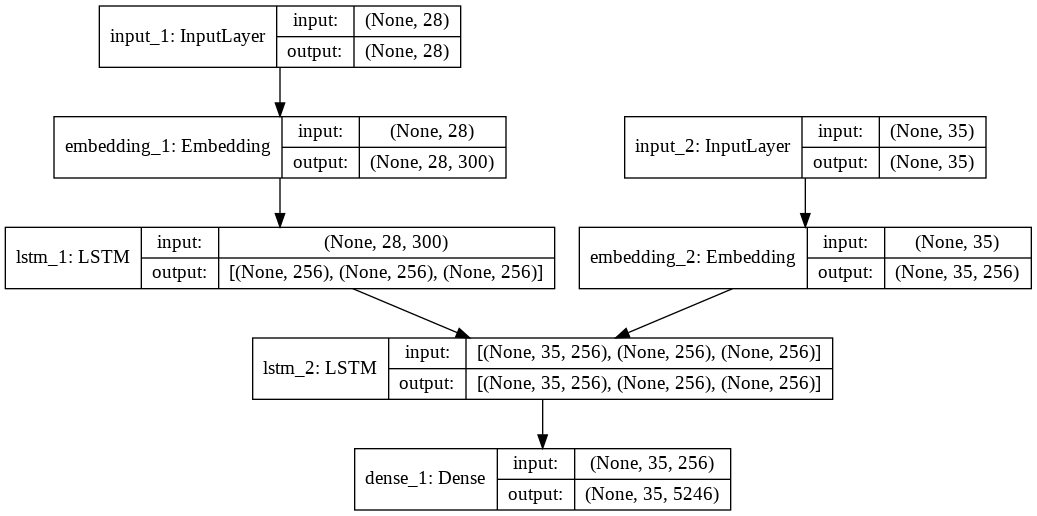

In [42]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Dari output, Anda dapat melihat bahwa kami memiliki dua jenis input. input_1 adalah tempat penampung input untuk encoder, yang tertanam dan melewati lapisan lstm_1, yang pada dasarnya adalah LSTM pembuat enkode. Ada tiga output dari lapisan lstm_1: output, layer tersembunyi dan status sel. Namun, hanya keadaan sel dan keadaan tersembunyi dilewatkan ke decoder.

Di sini lapisan lstm_2 adalah LSTM decoder. Input_2 berisi kalimat keluaran dengan token <sos> ditambahkan di awal. Input_2 juga dilewatkan melalui lapisan embedding dan digunakan sebagai input ke LSTM decoder, lstm_2. Akhirnya, output dari LSTM decoder dilewatkan melalui lapisan padat untuk membuat prediksi.

Langkah selanjutnya adalah melatih model menggunakan metode fit ():

In [43]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
from keras.callbacks import ModelCheckpoint
# define the checkpoint
filepath = "Model300.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [45]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,callbacks=callbacks_list
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2400 samples, validate on 600 samples
Epoch 1/200
2400/2400 [==============================] - 9s 4ms/step - loss: 3.5781 - accuracy: 0.5864 - val_loss: 2.7975 - val_accuracy: 0.6125

Epoch 00001: loss improved from inf to 3.57805, saving model to Model300.h5
Epoch 2/200
2400/2400 [==============================] - 7s 3ms/step - loss: 2.6464 - accuracy: 0.6239 - val_loss: 2.7530 - val_accuracy: 0.6172

Epoch 00002: loss improved from 3.57805 to 2.64643, saving model to Model300.h5
Epoch 3/200
2400/2400 [==============================] - 7s 3ms/step - loss: 2.5248 - accuracy: 0.6478 - val_loss: 2.6812 - val_accuracy: 0.6558

Epoch 00003: loss improved from 2.64643 to 2.52476, saving model to Model300.h5
Epoch 4/200
2400/2400 [==============================] - 7s 3ms/step - loss: 2.4501 - accuracy: 0.6597 - val_loss: 2.6859 - val_accuracy: 0.6671

Epoch 00004: loss improved from 2.5247

Saat berlatih, kita tahu input aktual ke decoder untuk semua kata output dalam urutan. 

Anda dapat melihat bahwa input ke decoder dan output dari decoder diketahui dan model dilatih berdasarkan input dan output ini.

Namun, selama prediksi kata berikutnya akan diprediksi berdasarkan kata sebelumnya, yang pada gilirannya juga diprediksi pada langkah waktu sebelumnya. Sekarang Anda akan memahami tujuan token <sos> dan <end>. Saat membuat prediksi aktual, urutan output penuh tidak tersedia, pada kenyataannya itulah yang harus kami prediksi. Selama prediksi, satu-satunya kata yang tersedia bagi kami adalah <sos> karena semua kalimat keluaran dimulai dengan <sos>.

#Load Model

In [0]:
from keras.models import load_model
# load model
model = load_model('/content/drive/My Drive/Colab Notebooks/Skripsi/Model/embedding100/Model300.h5')
model.load_weights("/content/drive/My Drive/Colab Notebooks/Skripsi/Model/embedding100/Model300.h5")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Pada langkah 1, keadaan tersembunyi dan keadaan sel encoder, dan <sos>, digunakan sebagai input ke decoder. Dekoder memprediksi kata y1 yang mungkin benar atau tidak. Namun, sesuai model kami, probabilitas prediksi yang benar adalah 0,7911. Pada langkah 2, keadaan tersembunyi decoder dan keadaan sel dari langkah 1, bersama dengan y1, digunakan sebagai input ke dekoder, yang memprediksi y2. Proses berlanjut hingga token <eos> ditemukan. Semua output yang diprediksi dari decoder kemudian digabungkan untuk membentuk kalimat output akhir. Mari kita modifikasi model kita untuk mengimplementasikan logika ini.

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [0]:
encoder_model.save('encoder_model300.h5')  # creates a HDF5 file 'my_model.h5'

Model encoder tetap sama

Karena sekarang pada setiap langkah kita membutuhkan dekoder hidden dan cell state, kita akan memodifikasi model kita untuk menerima keadaan tersembunyi dan sel seperti yang ditunjukkan di bawah ini:

In [0]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Sekarang pada setiap langkah waktu, hanya akan ada satu kata dalam input decoder, kita perlu memodifikasi layer embedding decoder sebagai berikut:

In [0]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

Selanjutnya, kita perlu membuat placeholder untuk output decoder:

In [0]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

Untuk membuat prediksi, output decoder dilewatkan melalui dense layer:

In [0]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

Langkah terakhir adalah menentukan model dekoder yang diperbarui, seperti yang ditunjukkan di sini

In [0]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [0]:
decoder_model.save('decoder_model300.h5')  # creates a HDF5 file 'my_model.h5'

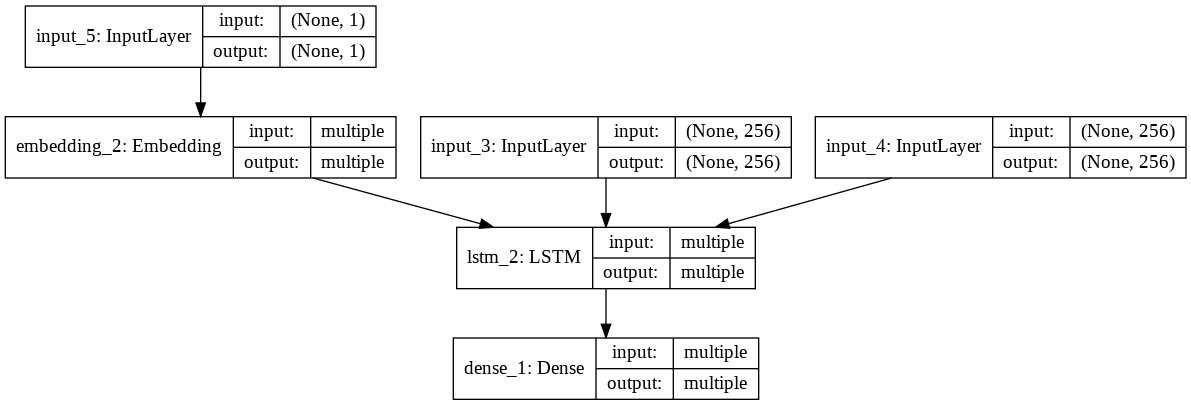

In [65]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

Pada gambar di atas, lstm_2 adalah dekoder LSTM yang dimodifikasi. Anda dapat melihat bahwa ia menerima kalimat dengan satu kata seperti yang ditunjukkan pada input_5, dan status sel dan tersembunyi dari output sebelumnya (input_3 dan input_4). Anda dapat melihat bahwa bentuk kalimat input sekarang (tidak ada, 1) karena hanya akan ada satu kata dalam input dekoder. Sebaliknya, selama pelatihan bentuk kalimat input adalah (Tidak ada, 6) karena input berisi kalimat lengkap dengan panjang maksimum 6.

#Membuat Prediksi

Pada langkah ini, Anda akan melihat bagaimana membuat prediksi menggunakan kalimat non-formal sebagai input.

Pada langkah-langkah tokenization, kami mengonversi kata menjadi bilangan bulat. Output dari decoder juga akan menjadi bilangan bulat. Namun, kami ingin hasil kami menjadi urutan kata dalam kalimat formal. Untuk melakukannya, kita perlu mengonversi bilangan bulat kembali ke kata-kata. Kami akan membuat kamus baru untuk input dan output di mana kunci akan menjadi bilangan bulat dan nilai yang sesuai akan menjadi kata-kata.

In [0]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [0]:
# Save
np.save('idx2word_input.npy', idx2word_input) 

In [0]:
# Save
np.save('idx2word_target.npy', idx2word_target) 

Selanjutnya kita akan membuat metode, yaitu translate_sentence (). Metode ini akan menerima urutan kalimat bahasa Inggris input-padded (dalam bentuk bilangan bulat) dan akan mengembalikan kalimat bahasa Prancis yang diterjemahkan. Lihatlah metode translate_sentence ():

In [0]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<end>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

Dalam skrip di atas kita meneruskan urutan input ke encoder_model, yang memprediksi keadaan tersembunyi dan keadaan sel, yang disimpan dalam variabel state_value.

* Selanjutnya, kita mendefinisikan variabel target_seq, yang merupakan matriks 1 x 1 dari semua nol. 
* Variabel target_seq berisi kata pertama ke model decoder, yaitu "sos"

* Setelah itu, variabel end diinisialisasi, yang menyimpan nilai integer untuk token "end". Pada baris berikutnya, daftar output_sentence didefinisikan, yang akan berisi terjemahan yang diprediksi.

* Selanjutnya, kita jalankan for. Jumlah siklus eksekusi untuk for loop sama dengan panjang kalimat terpanjang dalam output. 

* Di dalam loop, dalam iterasi pertama, decoder_model memprediksi output dan status sel dan tersembunyi, menggunakan status sel dan tersembunyi dari enkoder, dan token input, mis. <sos>. 
* Indeks kata yang diprediksi disimpan dalam variabel idx. Jika nilai indeks prediksi sama dengan token <eos>, loop berakhir. Lain jika indeks prediksi lebih besar dari nol, kata yang sesuai diambil dari kamus idx2word dan disimpan dalam variabel kata, yang kemudian ditambahkan ke daftar output_sentence. 
* Variabel States_value diperbarui dengan keadaan sel dan tersembunyi baru dari dekoder dan indeks kata yang diprediksi disimpan dalam variabel target_seq. 
* Dalam siklus loop berikutnya, status sel dan tersembunyi yang diperbarui, bersama dengan indeks kata yang diprediksi sebelumnya, digunakan untuk membuat prediksi baru. 
* Loop berlanjut hingga panjang urutan output maksimum tercapai atau token <eos> ditemukan.



Akhirnya, kata-kata dalam daftar output_sentence disatukan menggunakan spasi dan string yang dihasilkan dikembalikan ke fungsi pemanggilan.

#Testing Model

Untuk menguji kode, kita akan secara acak memilih kalimat dari daftar input_sentences, mengambil urutan padded yang sesuai untuk kalimat, dan akan meneruskannya ke metode translate_sentence (). 

In [56]:
encoder_input_sequences.shape

(3000, 28)

In [57]:
# i = np.random.choice(len(input_sentences))
i=120
print(input_sentences[i])
input_seq = encoder_input_sequences[i:i+1]
input_seq

pelaku pencurian dipukul sama balok kayu


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         200, 3009, 3010,   25, 3011,  585]], dtype=int32)

In [58]:
# i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
terjemahan = translate_sentence(input_seq)
print('Input:', input_sentences[i])
print('Response:', terjemahan)

Input: pelaku pencurian dipukul sama balok kayu
Response: pelaku pencurian dipukul dengan balok kayu


#Kesimpulan dan Perspektif

Terjemahan mesin saraf adalah aplikasi yang cukup maju dari pemrosesan bahasa alami dan melibatkan arsitektur yang sangat kompleks.

Artikel ini menjelaskan cara melakukan terjemahan mesin saraf melalui arsitektur seq2seq, yang pada gilirannya didasarkan pada model encoder-decoder. Encoder adalah LSTM yang mengkodekan kalimat input sedangkan decoder menerjemahkan input dan menghasilkan output yang sesuai. Teknik yang dijelaskan dalam artikel ini dapat digunakan untuk membuat model terjemahan mesin apa pun, selama dataset dalam format yang mirip dengan yang digunakan dalam artikel ini. Anda juga dapat menggunakan arsitektur seq2seq untuk mengembangkan chatbots.

Arsitektur seq2seq cukup berhasil ketika memetakan relasi input ke output. Namun, ada satu batasan untuk arsitektur seq2seq. Arsitektur vanilla seq2seq yang dijelaskan dalam artikel ini tidak mampu menangkap konteks. Ini hanya belajar memetakan input mandiri ke output mandiri. Percakapan real-time didasarkan pada konteks dan dialog antara dua atau lebih pengguna didasarkan pada apa pun yang dikatakan di masa lalu. Oleh karena itu, model seq2seq berbasis encoder-decoder sederhana tidak boleh digunakan jika Anda ingin membuat chatbot yang cukup canggih.

#Testing Kalimat Inputan

In [0]:
def preproces(input):
  from nltk.tokenize import RegexpTokenizer
  tokenizer = RegexpTokenizer(r'\w+')
  kata_input = tokenizer.tokenize(input)

  #tokenisasi
  test_word2idx = []
  for x in kata_input:
    try:
      test_word2idx.append(word2idx_inputs[x])
    except:
      test_word2idx.append(word2idx_inputs['unk'])
  
  # membuat list bantu
  list_bantu = [x for x in range(max_input_len)]

  # array untuk encoder
  jadi = []
  jadi.append(list_bantu)
  jadi.append(test_word2idx)

  encoder_input_sequences_test = pad_sequences(jadi, maxlen=28)

  return encoder_input_sequences_test[1:2]

#Data Testing

In [0]:
worksheet = gc.open('Dataset Kalimat').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
import pandas as pd
colsname=['formal','non-formal']
df_test = pd.DataFrame.from_records(rows,columns=colsname)
df_test = df_test[2600:3000]

In [61]:
df_test = df_test.reset_index(drop=True)
df_test

,formal,non-formal
0,inilah tantangan sekaligus peluang besar.,inilah tantangan sekaligus peluang besar.
1,sebenarnya para petani tidak merasa asing.,sebenernya para petani enggak ngerasa asing.
2,untuk itu kami juga membantu pengadaan tong fe...,untuk itu kita juga ngebantu pengadaan tong fe...
3,mereka rata-rata juga memelihara sapi atau kam...,mereka rata-rata juga pelihara sapi atau kambing.
4,sehingga menjadi pupuk organik cair.,sehingga jadi pupuk organik cair.
...,...,...
395,seperti pengemasan barang dan teknis pemasaran...,kayak pengemasan barang dan teknis pemasaran d...
396,gerakan umkm go online diisi berbagai pelatihan,gerakan umkm go online diisi berbagai pelatihan
397,kementerian komindo memfasilitasi umkm mengiku...,kementerian komindo memfasilitasi umkm ikuti p...
398,namun masih terdapat sejumlah hal yang harus d...,namun tetep ada sejumlah hal yang mesti disele...


In [0]:
def input_test(w):
  w = w.lower()
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = w.rstrip().strip()

  return w

input_sentences_test = []
for x in range(200):
  input_sentences_test.append(input_test(df_test['non-formal'][x]))

In [63]:
#data testing
for x in range(200):
  input_teks = input_sentences_test[x]
  input_seq = preproces(input_teks)
  terjemahan = translate_sentence(input_seq)
  print('Input:', input_teks)
  print('Response:', terjemahan)
  print('========================================================')

Input: inilah tantangan sekaligus peluang besar .
Response: pemerintah mengambil tambahan untung dalam tunai .
Input: sebenernya para petani enggak ngerasa asing .
Response: minat pengganda juga baik untuk meningkat .
Input: untuk itu kita juga ngebantu pengadaan tong fermentasi bagi kub ini buat pupuk organik
Response: hal itu dikarenakan masyarakat ataupun pemangku kebijakan terfokus pada penyelesaian masalah bencana ini .
Input: mereka rata-rata juga pelihara sapi atau kambing .
Response: mereka mulai akrab selesai hingga saat berdagang kue .
Input: sehingga jadi pupuk organik cair .
Response: dengan bulan , mereka tengah
Input: kotorannya daripada dibuang atau ditebar di ladang bakalan difermentasi
Response: ke 40 ke pasaran , ujilah suatu produk .
Input: “untuk itu kami juga ngebantu pengadaan tong fermentasi bagi kub ini , ” kata kepala bi perwakilan kediri djoko raharto .
Response: hal ini dikarenakan masyarakat ataupun pemangku kebijakan terfokus pada penyelesaian masalah semua

#Kalimat INputan

In [64]:
input_teks = 'nggak bisa'
input_seq = preproces(input_teks)
terjemahan = translate_sentence(input_seq)
print('Input:', input_teks)
print('Response:', terjemahan)

Input: nggak bisa
Response: tidak hanya
